In [180]:

from scipy import ndimage
from scipy.ndimage.filters import convolve
from matplotlib import pyplot as plt

import matplotlib.image as mpimg
import numpy as np

import cv2

/tmp/ipykernel_487/59636442.py:2: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [181]:
high_detalization = cv2.imread('data2/high_det.jpg', 0)
low_detalization = cv2.imread('data2/low_det.jpg', 0)
high_contrast = cv2.imread('data2/high_con.jpg', 0)
low_contrast = cv2.imread('data2/low_con.jpg', 0)


In [182]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [195]:
sigma=1.4
kernel_size=5
lowhreshold=0.09
highthreshold=0.17
weak_pixel=100

**STEP 1 - Noise Reduction**
Позбуваємось від зашумлення зобраення за допомогою Гаусівського розмиття.
Для цього застосовується техніка згортки зображень із ядром Гаусса.
Чим найменше ядро - тим менш помітним є розмиття.

In [184]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

**STEP 2 - Gradient Calculation**
Позбуваємось від зашумлення зобраення за допомогою Гаусівського розмиття.
Для цього застосовується техніка згортки зображень із ядром Гаусса.
Чим найменше ядро - тим менш помітним є розмиття.

In [185]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return (G, theta)

In [186]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180


    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0


            except IndexError as e:
                pass

    return Z

In [187]:
def threshold(img, highThreshold = 1, lowThreshold = 1, strong_pixel = 255):

    highThreshold = img.max() * highThreshold;
    lowThreshold = highThreshold * lowThreshold;

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(weak_pixel)
    strong = np.int32(strong_pixel)

    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)

    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res)

In [188]:
def hysteresis(img, strong_pixel = 255):

    M, N = img.shape
    weak = weak_pixel
    strong = strong_pixel

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass

    return img

In [189]:
def detect(img):
    img_smoothed = convolve(img, gaussian_kernel(kernel_size, sigma))
    gradientMat, thetaMat = sobel_filters(img_smoothed)
    nonMaxImg = non_max_suppression(gradientMat, thetaMat)
    thresholdImg = threshold(nonMaxImg, highthreshold, lowhreshold)
    img_final = hysteresis(thresholdImg)
    return img_final

In [190]:
def show_res(img):
    plt.figure(figsize=(20, 40))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.subplot(122)
    plt.imshow(detect(img), cmap='gray', vmin=0, vmax=255)

In [191]:
low_detalization = rgb2gray(mpimg.imread('data2/low_det.jpg'))
high_detalization = rgb2gray(mpimg.imread('data2/high_det.jpg'))
# low_contrast = rgb2gray(mpimg.imread('data2/low_con.jpg'))
low_contrast = rgb2gray(mpimg.imread('data2/lower_con.jpeg'))
high_contrast = rgb2gray(mpimg.imread('data2/high_con.jpg'))

imgs = [low_detalization, high_detalization, low_contrast, high_contrast]

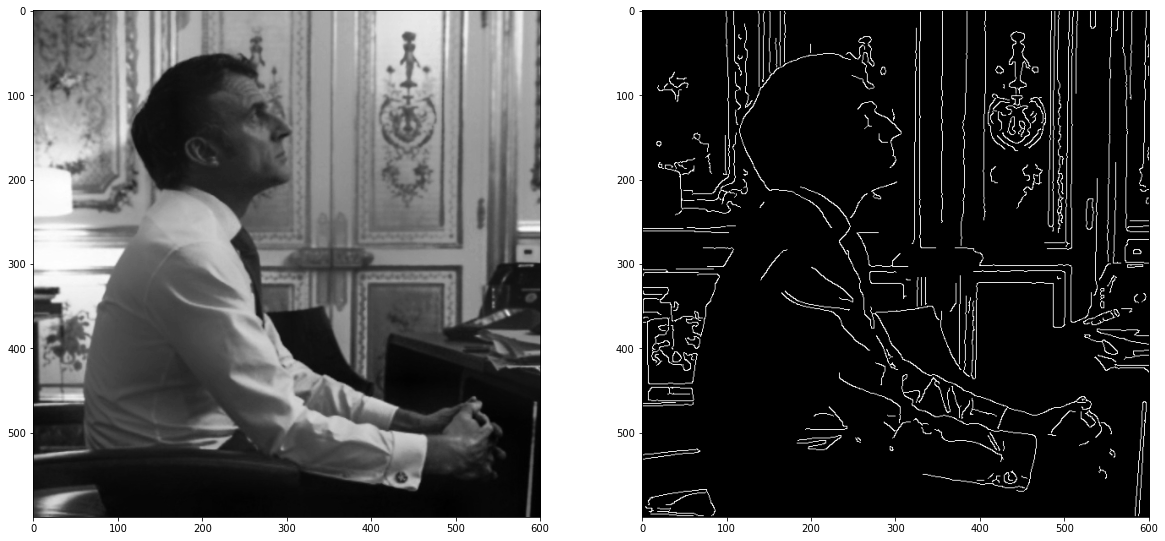

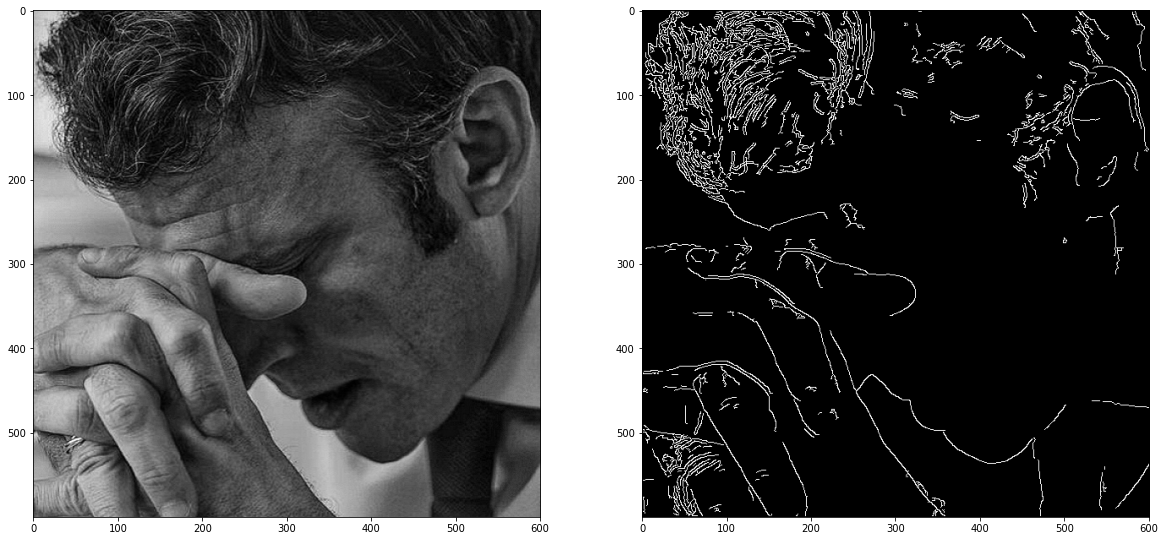

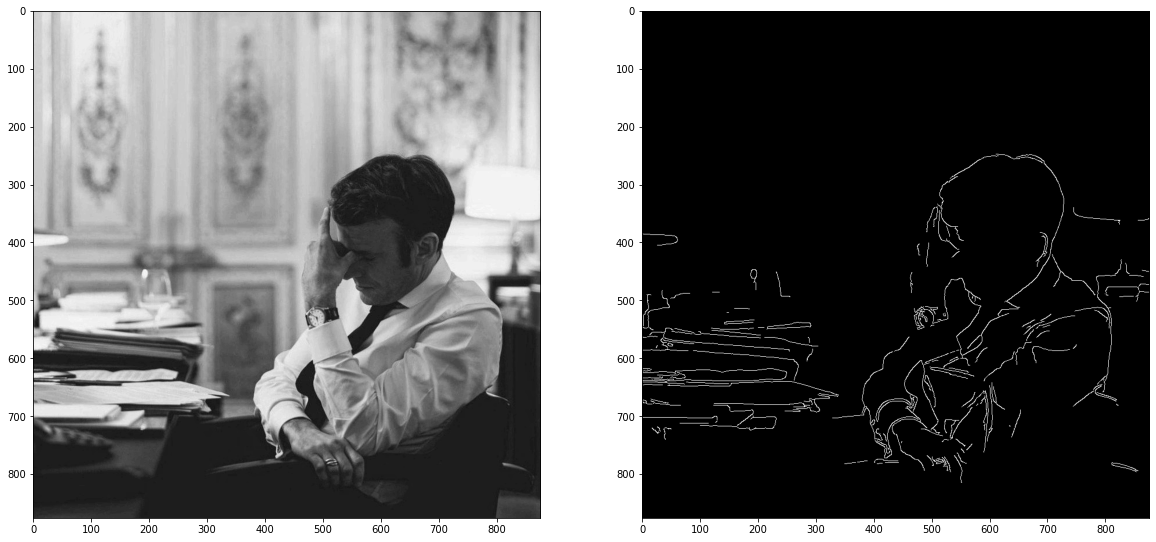

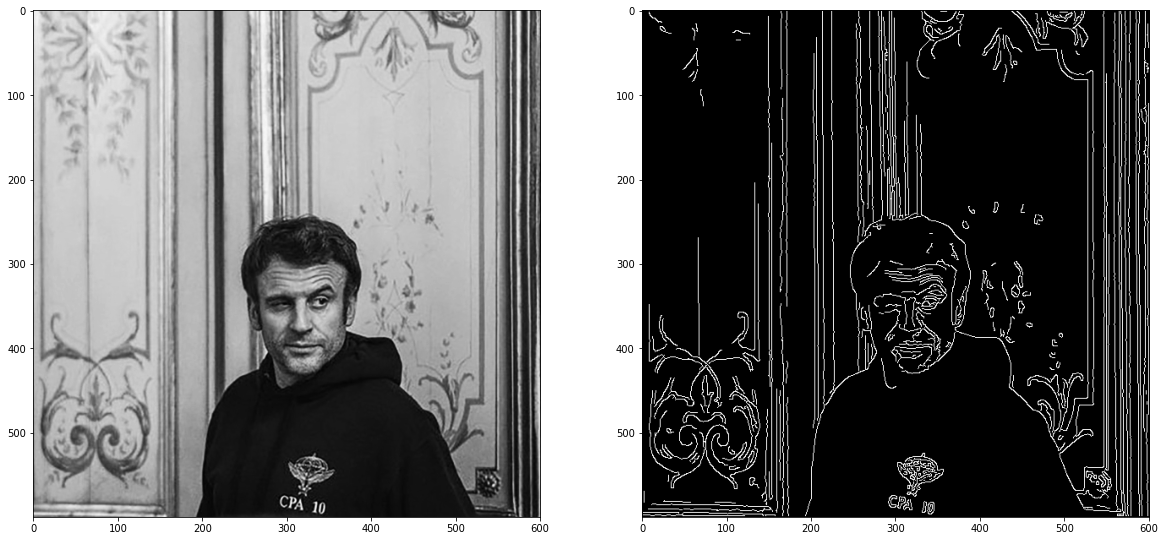

/tmp/ipykernel_487/3501145529.py:5: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Ix = ndimage.filters.convolve(img, Kx)
/tmp/ipykernel_487/3501145529.py:6: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Iy = ndimage.filters.convolve(img, Ky)


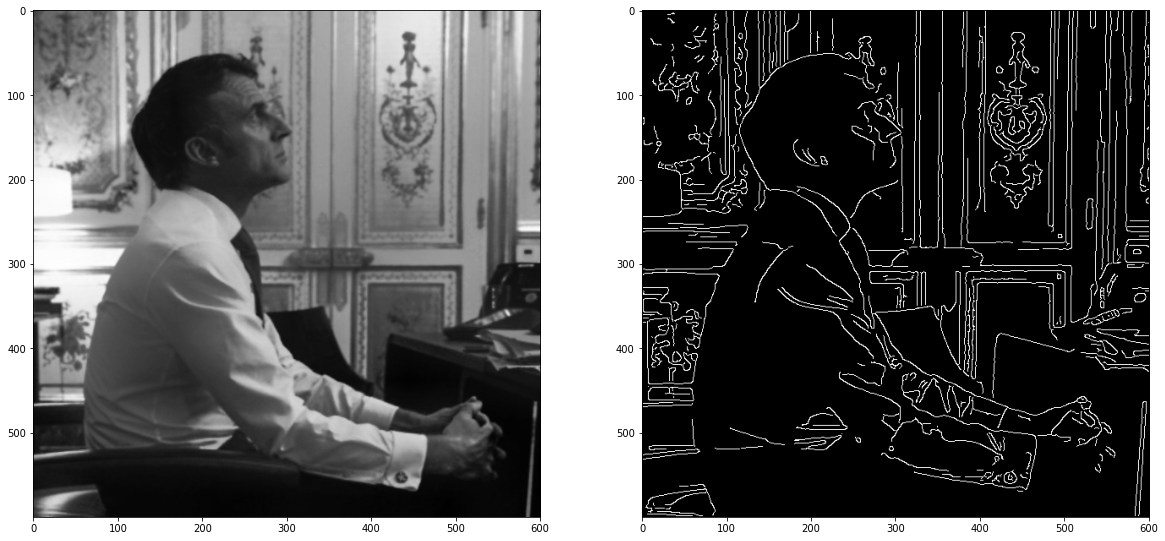

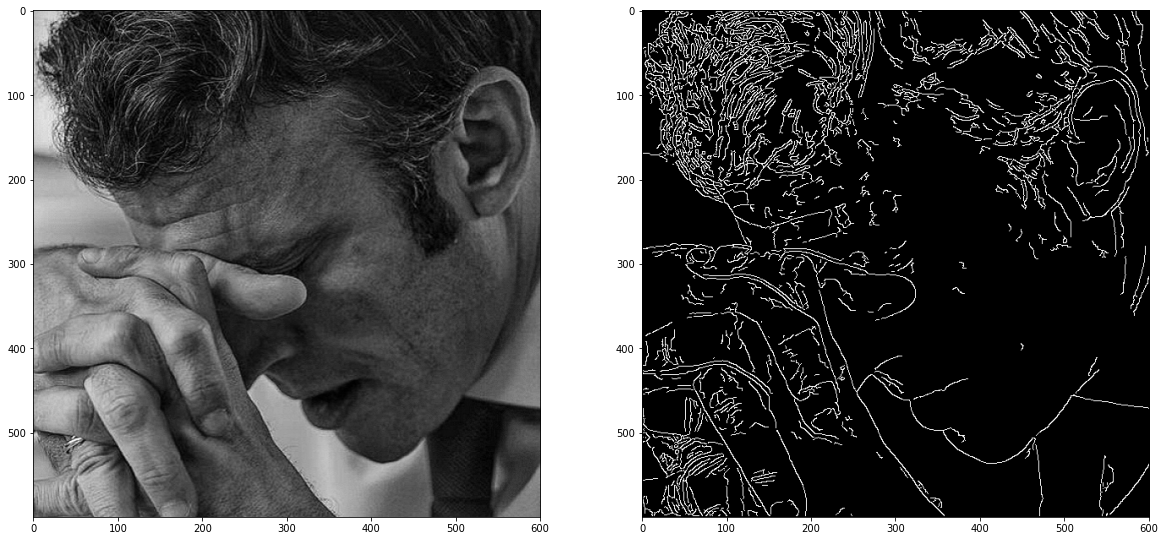

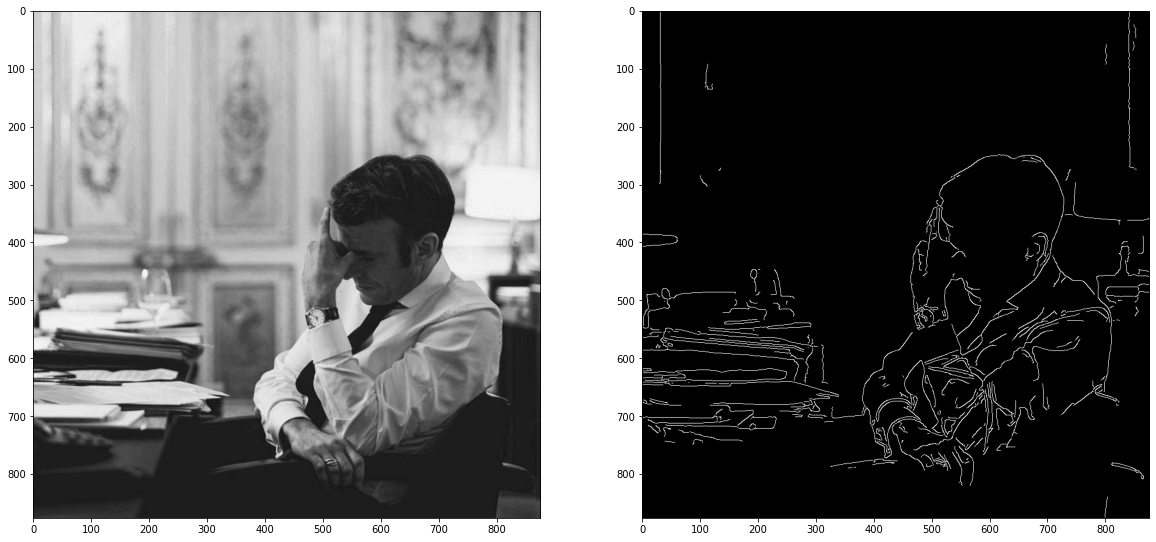

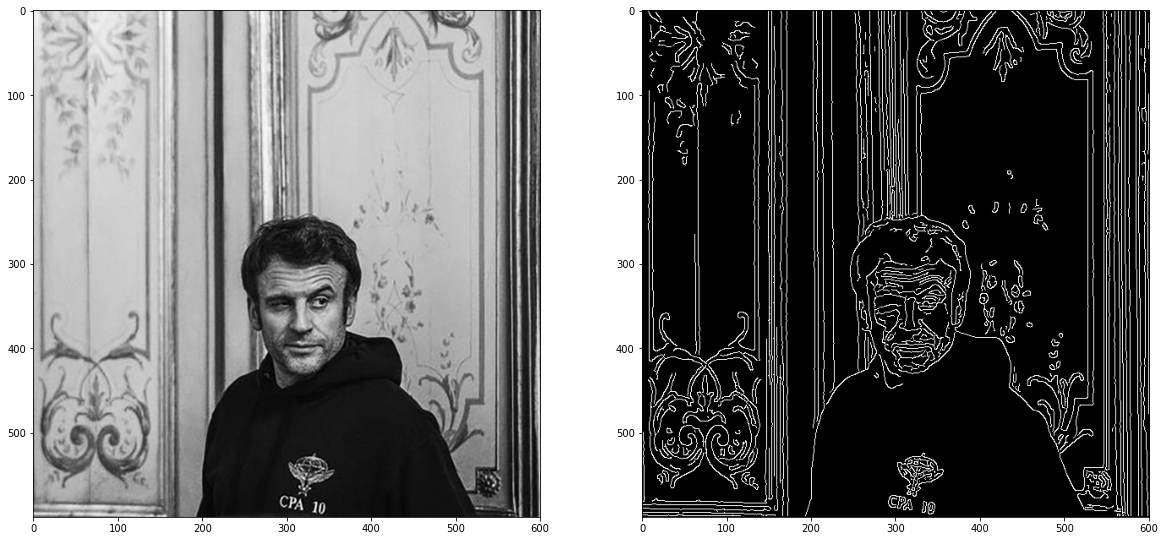

In [192]:
for i in imgs:
    show_res(i)

In [206]:
low_detalization = rgb2gray(mpimg.imread('data/low_det.jpeg'))
high_detalization = rgb2gray(mpimg.imread('data/high_det.jpeg'))
low_contrast = rgb2gray(mpimg.imread('data/low_con.jpg'))
high_contrast = rgb2gray(mpimg.imread('data/high_con.jpeg'))

imgs = [low_detalization, high_detalization, low_contrast, high_contrast]

/tmp/ipykernel_487/3501145529.py:5: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Ix = ndimage.filters.convolve(img, Kx)
/tmp/ipykernel_487/3501145529.py:6: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Iy = ndimage.filters.convolve(img, Ky)


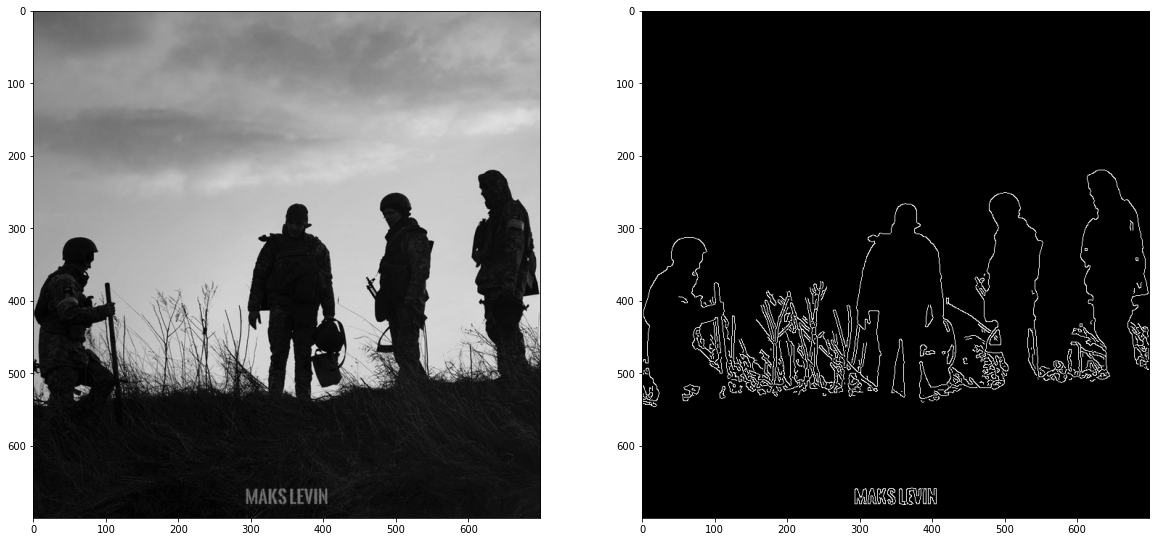

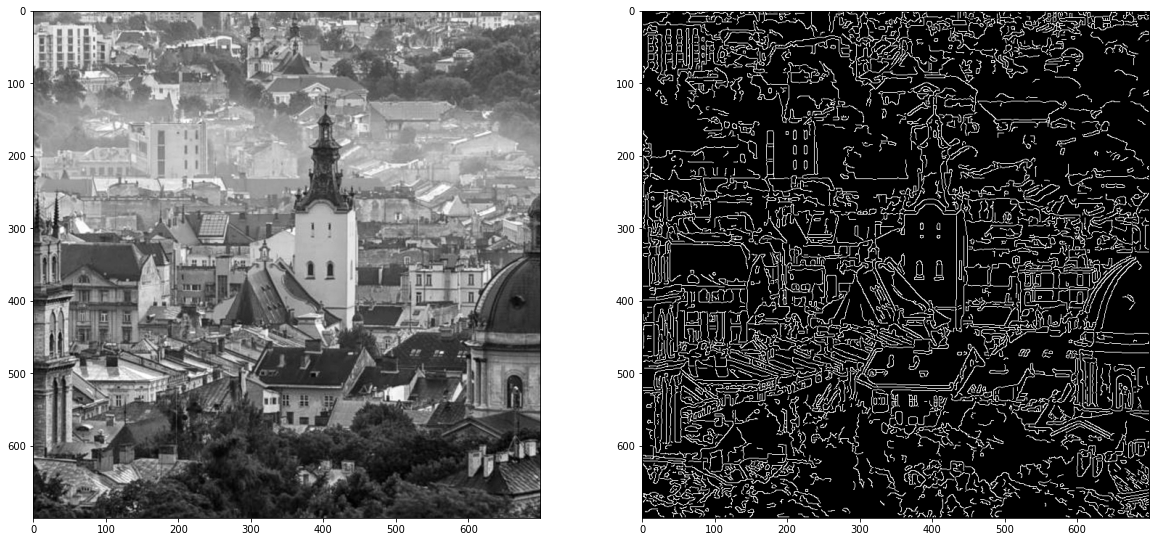

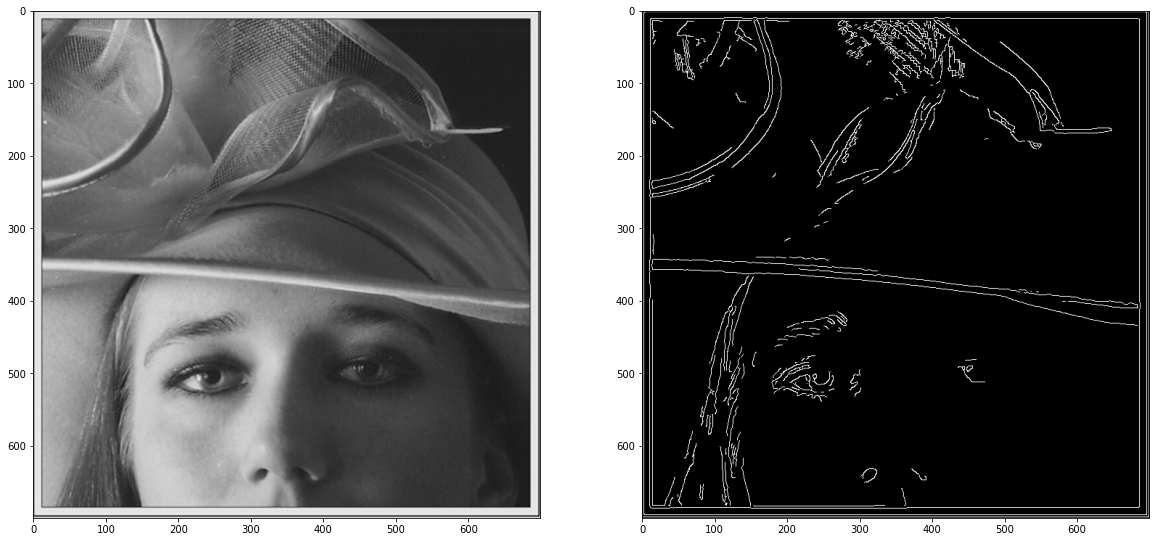

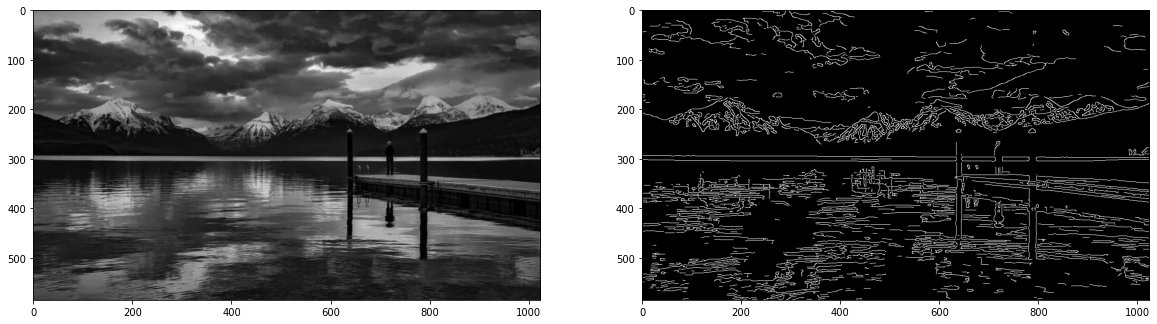

In [207]:
for i in imgs:
    show_res(i)